In [1]:
%%capture
help('modules')
from pgljupyter import LsystemWidget

In [2]:
PROBA_GENERATE = False
if PROBA_GENERATE:
    import os
    from openalea.vmango.preparation.glm_estimation.get_data_for_glm import main as get_data_for_glm
    import rpy2.robjects as r

    print(os.getcwd())
    #os.chdir('../src/openalea/vmango/preparation/glm_estimation')
    os.chdir('../preparation/glm_estimation')
    # generate input files located at glm_estimate_input/{cultivar} for prob. tables
    get_data_for_glm()

    # generate prob. tables at glm_output_proba/{cultivar}
    rscript = 'estimate_nb_glm_order_1_proba.r'
    r.r(f"source('{rscript}')")

In [3]:
import os
if not os.path.exists('mango_simulation.lpy'):
    os.chdir('../src/openalea/vmango/simulation')

# Simulation of a mango trees for 2 growing cycles

In [4]:
lw = LsystemWidget('mango_simulation.lpy', unit='cm', size_display=(800, 600), size_world=5)

In [5]:
lw

LsystemWidget(derivationLength=12, scene={'data': b'x\xda\xcc\xbd\x07T\x14\xcb\x16\xb0\x0b\xa2\x82\x80\x12U\x9…

Fruit model evaluation 2004-08-19 for cycle 4


In [6]:
lw.editor

ParameterEditor(children=(VBox(children=(HBox(children=(HBox(children=(Button(description='Apply changes', sty…

# Analysis of the resulting structure

We first retrieve the resulting structure (in this case as a MTG) from the simulation. It will then be parsed to characterize the results of the simulation.

In [16]:
result = lw.get_namespace()['resultmtg']

In [17]:
from openalea.vmango.preparation.doralice_mtg.mtg_manipulation import *
from openalea.vmango.utilities.util_date import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from collections import OrderedDict
setMtgStyle(eSimulatedMtg)

# Fruit production

We compute the distribution of estimated harvest date

In [18]:
harvestdaterange = (weekdate_range(fruiting_cycle_begin(4),fruiting_cycle_end(4)+ timedelta(days=21)))

def harvest_week_distribution(mtg):
    def toweekid(inflo):
        date = get_fruits_harvest_date(mtg,inflo)
        if date is None: return (2000+get_unit_cycle(mtg,inflo),None)
        d = date.isocalendar()
        return (d[0],d[1]) 

    histo_date = OrderedDict([(d,0) for d in harvestdaterange])
    setMtgStyle(eSimulatedMtg)
    inflos = get_all_inflo_of_variety_at_cycle(mtg,4)
    fruit_weights = []
    for inflo in inflos:
        if get_nb_fruits(mtg,inflo) > 0:
           fruit_weights.append(get_fruits_weight(mtg, inflo))
           if not toweekid(inflo) in histo_date:
              print('Cannot consider',toweekid(inflo))
           else:
               histo_date[toweekid(inflo)] += get_nb_fruits(mtg,inflo)
    return list(histo_date.values()), fruit_weights

def plot_harvest_distribution(values):
    import matplotlib.pyplot as plt
    #strdate = lambda d : str(d[1])# +'-'+str(d[0]-2000)
    dates     = list(map(lambda d : str(d[1])+'/'+str(d[0])[2:], harvestdaterange))
    fig, ax = plt.subplots()
    plt.bar(dates,values)
    ax.set_xticklabels(dates, rotation=80)
    plt.xlabel('Weeks'); plt.ylabel('Number of fruits')
    plt.plot()
    
def plot_weight_distribution(values):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.hist(weigths,range(0,1200,100))
    plt.xlabel('Weights'); plt.ylabel('Number of fruits')
    plt.plot()

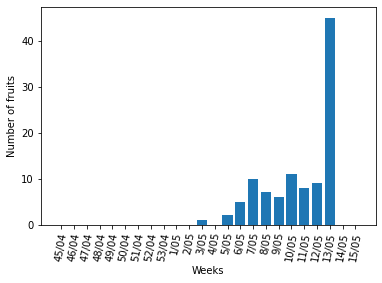

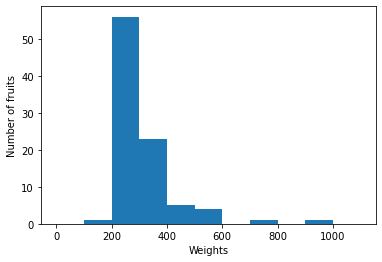

In [19]:
harvest, weigths = harvest_week_distribution(result)
plot_harvest_distribution(harvest)
plot_weight_distribution(weigths)

## GU distribution

We give here an algorithm to determine the number of GUs appearing each month of the simulated period. For this we simply check the burst date of each GU.

In [20]:

daterange = monthdate_range(vegetative_cycle_end(3),vegetative_cycle_end(5))

def determine_gu_distribution(mtg):
    setMtgStyle(eSimulatedMtg)
    histo_date = OrderedDict([(d,0) for d in daterange])
    for uc in get_all_gus_of_variety(mtg):
        try:
            d = get_burst_date(mtg,uc)
            histo_date[(d.year,d.month)] += 1
        except : pass
    return list(histo_date.values())

def plot_distribution(values):
    import matplotlib.pyplot as plt
    dates     = list(map(lambda d : MonthEnName[d[1]][:3]+'-'+str(d[0]-2000).zfill(2), daterange))
    fig, ax = plt.subplots()
    plt.bar(dates,values)
    ax.set_xticklabels(dates, rotation=80)
    plt.xlabel('Month'); plt.ylabel('Number of new growth units')

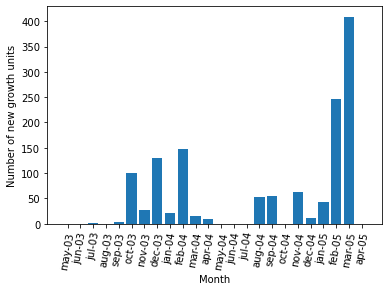

In [21]:
gudistrib = determine_gu_distribution(result)
plot_distribution(gudistrib)

## Current Year Axes Size Distribution

The number of GUs borned from the same initial GU of the initial structure is computed. The distribution of size is then displayed. This allow to compare vigour of the different initial GUs.

In [22]:
import numpy as np

def determine_length_histogram(mtg):
    setMtgStyle(eSimulatedMtg)
    ucs = [uc for uc in get_all_gus_of_variety(mtg) if get_unit_cycle(mtg, uc) > 3]
    roots = [uc for uc in ucs if get_unit_cycle(mtg,uc) != get_unit_cycle(mtg,mtg.parent(uc))]
    groupid = dict([(uc,uc) for uc in  roots])
    for uc in ucs :       
        if not uc in groupid:
            parents = []
            while not uc in groupid:
                parents.append(uc)
                uc = mtg.parent(uc)
            gid = groupid[uc]
            for p in parents:
                groupid[p] = gid
    histo = np.bincount(np.bincount(list(groupid.values())))[1:]
    return histo

def plot_length_histogram(values):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.bar(range(len(values)),values)
    #ax.set_xticklabels(dates, rotation=80)
    plt.title('Current Year Axes Size Distribution')
    plt.xlabel('Number of GUs in current year axes'); plt.ylabel('Number of current year axes')

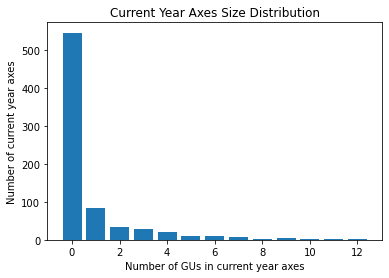

In [23]:
h = determine_length_histogram(result)
plot_length_histogram(h)

## Stage Duration

In this analysis, a heat map for vegetative and flowering development is displayed. Green channel specify number of GUs that develop while red channel the number of inflorescences developping. Yellow channel show period when development is mixed on the tree. A log scale is used.

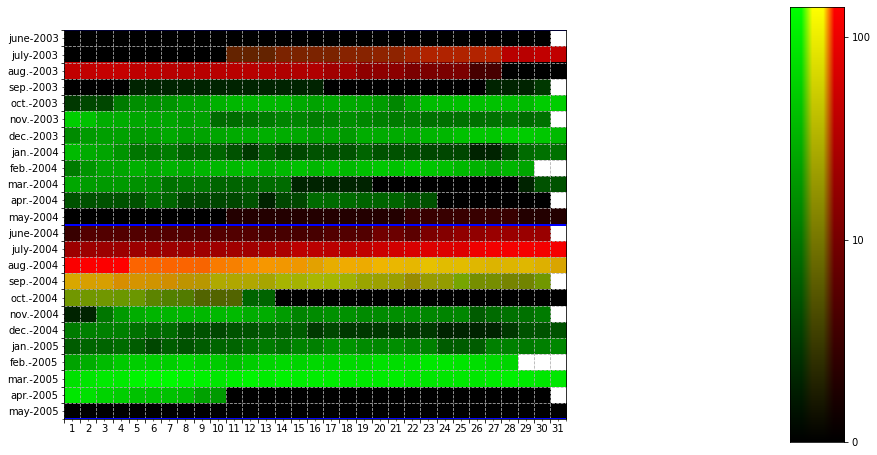

In [24]:
import imp
import openalea.vmango.validation.result_analysis as ra
imp.reload(ra)

ra.stage_evaluator().applyTo(result)